In [7]:
import numpy as np
from MCMC_aux import get_model
import Parameters as par
import Models as mod
import Kernels as ker
import GP_Likelihood as gp
from MCMC import run_MCMC as run
import plotting as plot
from saving import save
import auxiliary as aux

## Generating Fake Data
Much like tutorial 1 and 2, we start by generating some fake cosine data to represent the activity. This time we simulate using multiple data sets possibly from multiple telescopes and therefore potentially with different offsets. We do this by defining 3 different time, rv and rv error arrays that all plot the same cosine curve but each with their own small noise term. Here, time1 and rv1 is acting as our baseline data that we want to calibrate the offsets of the other data to so we don't give the fake data an offset but we give a +50 offset to rv2 and a +20 offset to rv3.

In [8]:
# set up the 3 different time arrays 
time1 = np.arange(0., 40., 4.)
time2 = np.arange(0.5, 40.5, 5.)
time3 = np.arange(1.3, 41.3, 8.)
# set up cosine amplitude and period
A = 10.
P = 10.
# set up noise term
err = []
for i in time1:
    err.append(np.random.uniform(-3,3))
# rv1 has no offset
rv1 = A*np.cos(time1*((2*np.pi)/P))+err
rv1_err = np.ones_like(rv1)*4

err = []
for i in time2:
    err.append(np.random.uniform(-3,3))
# rv2 has a +50 offset
rv2 = A*np.cos(time2*((2*np.pi)/P))+err+50
rv2_err = np.ones_like(rv2)*5

err = []
for i in time3:
    err.append(np.random.uniform(-3,3))
# rv3 has a +20 offset
rv3 = A*np.cos(time3*((2*np.pi)/P))+err+20
rv3_err = np.ones_like(rv3)*3

The combine_data function turns these 3 data sets into 1 large dataset. It orders the data in order of times and assigns flags to each point which are returned in the flags array. These flags indicate which data set the point was originally from. The order of the data inputted into this function is very important as the first data, in this case time1 and rv1, always relates to the data indended to be used as the baseline. This means when applying offsets further into the code, these offsets will only apply to the data not in the first position, effectively calibrating it to the first data set.

In [9]:
# this can take any number of datasets however the current plotting code can only take a maximum of 6
time, rv, rv_err, flags = mod.combine_data([time1,time2,time3], [rv1,rv2,rv3], [rv1_err,rv2_err,rv3_err])

Whilst it is not neccesary anywhere in the following code, it is possible to obtain the offset subtracted rv data by running the offset_subtract function along with the combined rvs, the flags, and the offsets. The order of this offsets should follow the order of the data inputed into the combine_data function, in this case 50 will be subtracted from rv2 and 20 will be subtracted from rv3.

In [10]:
# obtain offset rvs, this is not needed for the code and should not be inputted into any of the following functions
offset_rv = plot.offset_subtract(rv, flags, [50,20])

Similarly to creating the polynomial in tutorial 2, we now create 2 Keplerians to inject into the data

In [11]:
# function allows for generations of keplerians
def ecc_anomaly(M, ecc, max_itr=200):
    '''
    ----------
    M : float
        Mean anomaly
    ecc : float
        Eccentricity, number between 0. and 0.99
    max_itr : integer, optional
        Number of maximum iteration in E computation. The default is 200.
    Returns
    -------
    E : float
        Eccentric anomaly
    '''
    
    E0 = M
    E = M
    #print("E before = ", E)
    for i in range(max_itr):
        f = E0 - ecc*np.sin(E0) - M
        fp = 1. - ecc*np.cos(E0)
        E = E0 - f/fp
        
        # check for convergence
        if (np.linalg.norm(E - E0, ord=1) <= 1.0e-10):
            return E
            break
        # if not convergence continue
        E0 = E
    
    # no convergence, return best estimate
    #print('Best estimate E = ',E[0:5])
    return E

# keplerian 1 parameters
K = 30
ecc = 0.5
omega = np.pi/2.
Pl = 7.2
t0 = time[0]

M = 2*np.pi * (time-t0) / Pl
E = ecc_anomaly(M, ecc)
nu = 2. * np.arctan(np.sqrt((1.+ecc)/(1.-ecc)) * np.tan(E/2.))

# generate keplerian 1 and add it to the data
Kep = K * (np.cos(omega + nu) + ecc*np.cos(omega))
rv = rv + Kep

# keplerian 2 parameters
K = 38
ecc = 0.7
omega = np.pi/4
Pl = 5.6
t0 = time[0]

M = 2*np.pi * (time-t0) / Pl
E = ecc_anomaly(M, ecc)
nu = 2. * np.arctan(np.sqrt((1.+ecc)/(1.-ecc)) * np.tan(E/2.))

# gernerate keplerian 2 and add it to the data
Kep2 = K * (np.cos(omega + nu) + ecc*np.cos(omega))
rv = rv + Kep2

The data_plot function works mostly the same as in the past except now it requires a flags input and an offsets input. The offset input works the same as the offset input to offset_subtract where the order should be the same as the order of the data in combine_data. In this case 50 will be subtracted from rv2 and 20 will be subtracted form rv3.

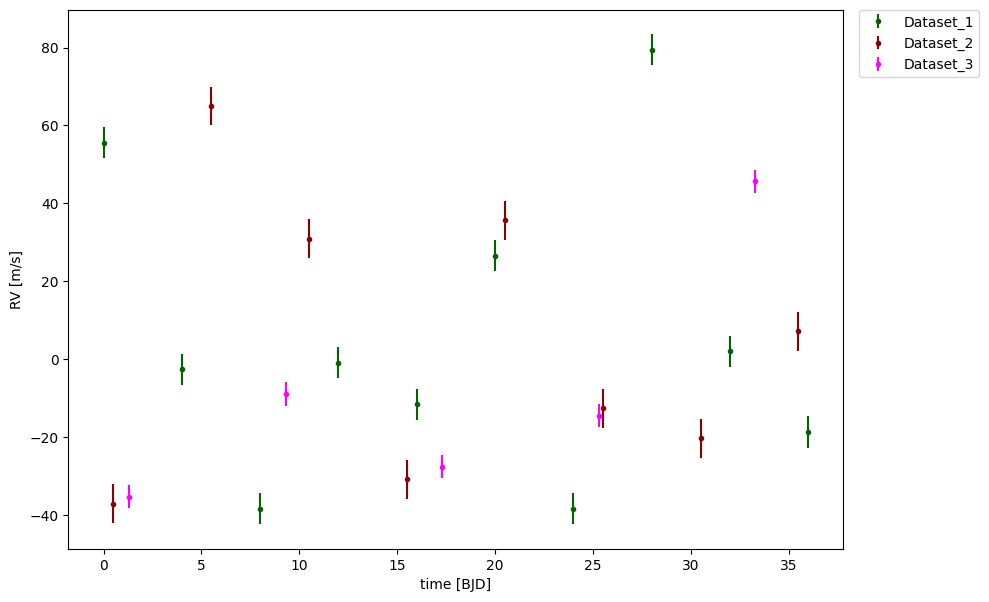

In [16]:
# view the combined data with any offsets subtracted
plot.data_plot(time, rv, y_err = rv_err, flags = flags, offsets = [50,20])

## Creating the Kernel and the Models
The kernel and the model are created in the exact same way using the same functions as the previous tutorials, the only difference this time being we have multiple models. A Cosine kernel is used along with 2 Keplerian models and 2 Offset models. Importantly, the order of the offset models is the same order as the data was inputted inot combine_data so in this case offset_0 correlates to the offset of rv2 and offset_1 correlates to the offset of rv3.

We will once again skip over the GPLikeihood funcitons as these are not neccessary for the code to run but the steps to obtain initial LogL and GP y values are identical to tutorial 2.

In [18]:
# set up the cosine kernel
hparam = par.par_create("Cosine")
hparam["gp_amp"] = par.parameter(value = 10., error = 0.5, vary = True)
hparam["gp_per"] = par.parameter(value = 10., error = 0.5, vary = True)
#set up the kernel priors
prior_list = []
pri_amp = par.pri_create("gp_amp", "Uniform", [0.,20.])
prior_list.append(pri_amp)
pri_per = par.pri_create("gp_per", "Uniform", [0.,20.])
prior_list.append(pri_per)
# the model list contians 2 keplerians and 2 offsets, the order is unimportant
model_list = ["Keplerian", "Offset", "Offset", "Keplerian"]
model_par = mod.mod_create(model_list)
# set up the model parameters
model_par["P_0"]=par.parameter(value=7.2, error=0.5, vary=True)
model_par["K_0"]=par.parameter(value=30., error=1., vary=True)
model_par["ecc_0"]=par.parameter(value=0.5, error=0.1, vary=True)
model_par["omega_0"]=par.parameter(value=np.pi/2, error=0.05, vary=True)
model_par["t0_0"]=par.parameter(value=0., error=0.1, vary=True)
model_par["P_1"]=par.parameter(value=5.6, error=0.5, vary=True)
model_par["K_1"]=par.parameter(value=38., error=1., vary=True)
model_par["ecc_1"]=par.parameter(value=0.7, error=0.1, vary=True)
model_par["omega_1"]=par.parameter(value=np.pi/4, error=0.05, vary=True)
model_par["t0_1"]=par.parameter(value=0., error=10., vary=True)
# offset_0 refers to the offset of rv2
model_par["offset_0"] = par.parameter(50., 0.5, True)
# offset_1 refers to the offset of rv3
model_par["offset_1"] = par.parameter(20., 0.5, True)
# set up model priors
pri_val = par.pri_create("P_0", "Uniform", [0.,10.])
prior_list.append(pri_val)
pri_val = par.pri_create("K_0", "Uniform", [0.,60.])
prior_list.append(pri_val)
pri_val = par.pri_create("ecc_0", "Uniform", [0.,1.])
prior_list.append(pri_val)
pri_val = par.pri_create("omega_0", "Uniform", [0.,5.])
prior_list.append(pri_val)
pri_val = par.pri_create("t0_0", "Uniform", [0.,5.])
prior_list.append(pri_val)
pri_val = par.pri_create("P_1", "Uniform", [0.,10.])
prior_list.append(pri_val)
pri_val = par.pri_create("K_1", "Uniform", [0.,60.])
prior_list.append(pri_val)
pri_val = par.pri_create("ecc_1", "Uniform", [0.,1.])
prior_list.append(pri_val)
pri_val = par.pri_create("omega_1", "Uniform", [0.,5.])
prior_list.append(pri_val)
pri_val = par.pri_create("t0_1", "Uniform", [0.,5.])
prior_list.append(pri_val)
pri_val = par.pri_create("offset_0", "Uniform", [40.,60.])
prior_list.append(pri_val)
pri_val = par.pri_create("offset_1", "Uniform", [0.,30.])
prior_list.append(pri_val)

## Plotting Initial Conditions
The same plotting functions as tutorial 3 are used to plot the initial parameters, this can also be done at the end similarly to tutorial 3 but in this case the data is fake and we know the exact values so these plots should fit almost perfectly. We are able to choose which kerplerian we plot by changing the keplerian_number in the kerplerian only plots and the phase plots. These functions all now require the extra input of flags to plot the different data and adjust for the offsets properly.

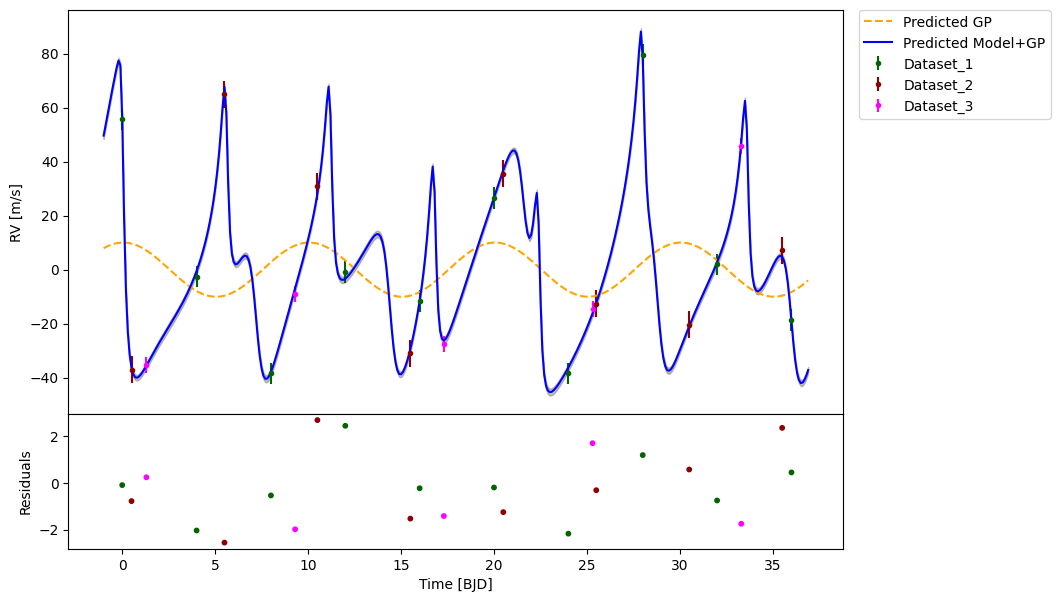

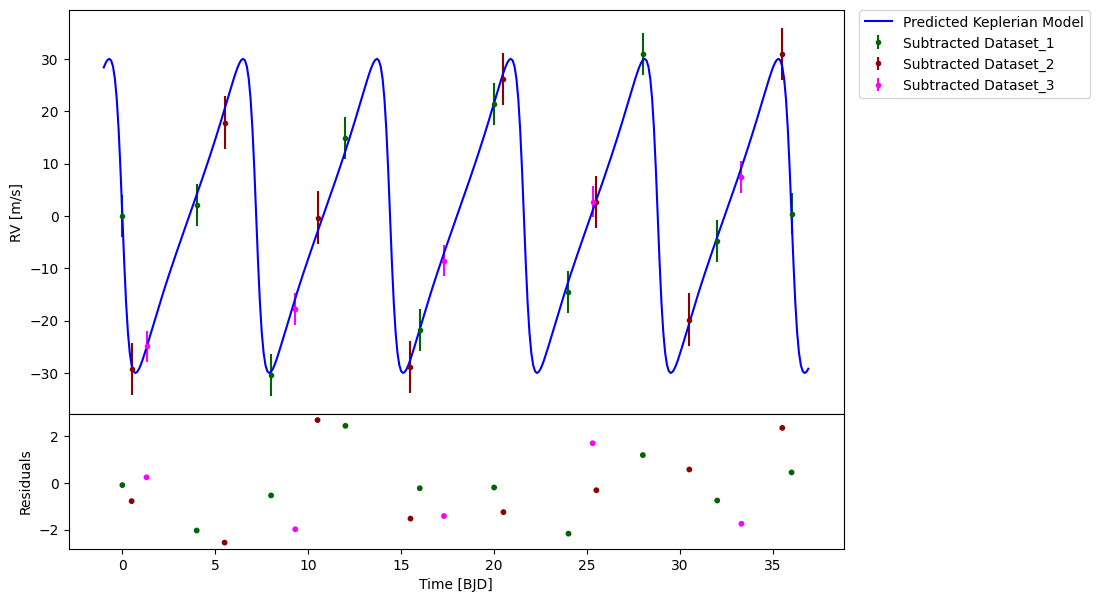

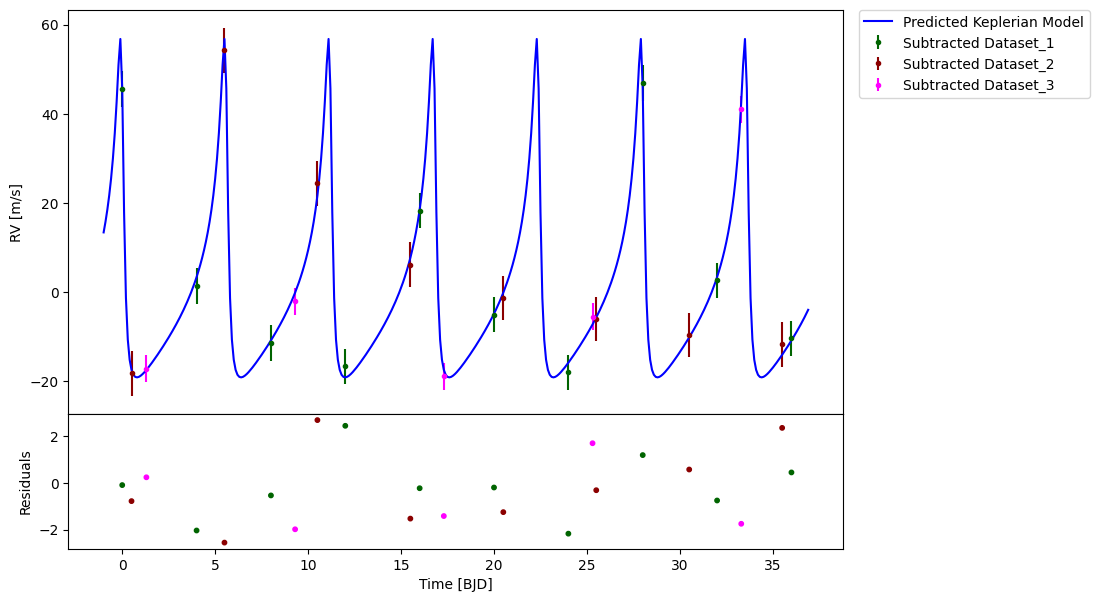

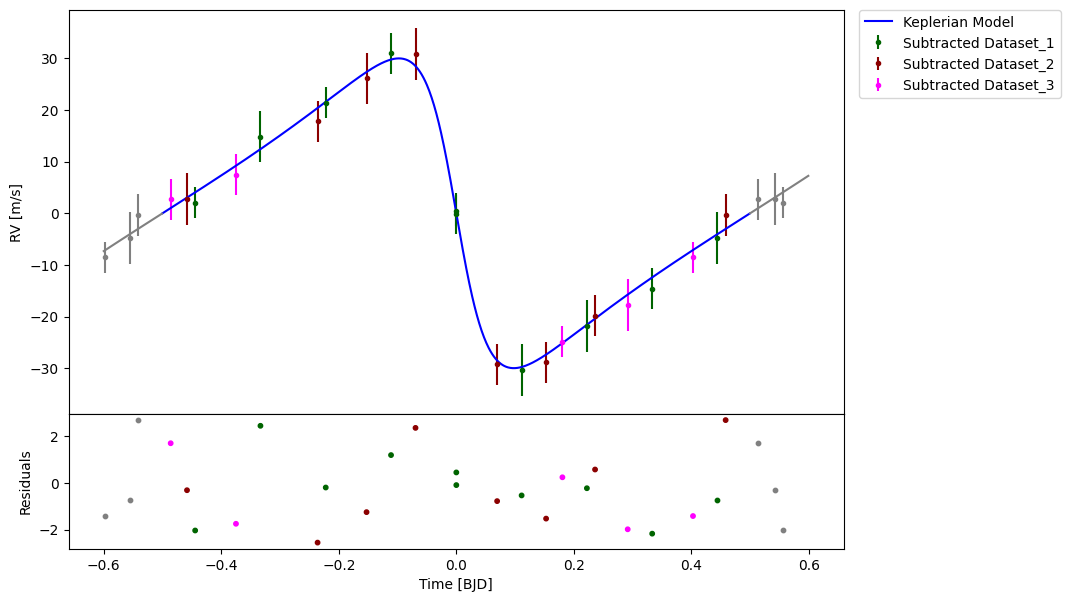

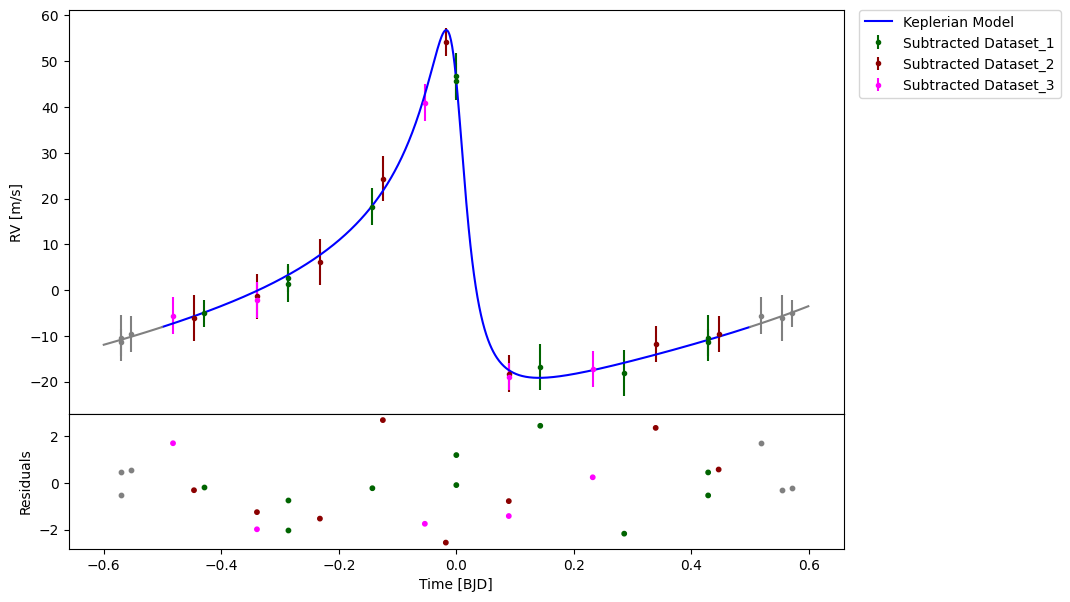

In [19]:
# plot of the offset subtracted data along with the GP in orange and all models plus GP in blue 
plot.GP_plot(time, rv, hparam, "Cosine", rv_err = rv_err, model_list = model_list, model_param = model_par, flags = flags, residuals = True)
# keplerian only plot relating to the kerplerian with parameters P_0, K_0, ecc_0, omega_0, t0_0. Offsets, GP and other models subtracted from the data
plot.keplerian_only_plot(time, rv, hparam, "Cosine", model_list, model_par, rv_err, flags = flags, keplerian_number = 0, residuals = True)
# keplerian only plot relating to the kerplerian with parameters P_1, K_1, ecc_1, omega_1, t0_1. Offsets, GP and other models subtracted from the data
plot.keplerian_only_plot(time, rv, hparam, "Cosine", model_list, model_par, rv_err, keplerian_number = 1, residuals = True, flags = flags)
# similar to kerplerian only but phase folded instead
plot.phase_plot(time, rv, hparam, "Cosine", model_list, model_par, rv_err, flags = flags, keplerian_number = 0, residuals = True)
plot.phase_plot(time, rv, hparam, "Cosine", model_list, model_par, rv_err, flags = flags, keplerian_number = 1, residuals = True)

## Running the MCMC
The MCMC is run in the same way as the previous tutorials however this time we are calculating the mass of these planets. To run with offsets, the run mcmc function requires flags as an input. To calculate the masses of the keplerians, we must give an extra output, in this case masses, and an extra input of Mstar, the mass of the host star in solar masses. The 5th output, masses, will return a 3d array with nrows = chains, ncolumns = keplerian, ndimensions = iterations. So in this case masses will have 2 columns, the first column being the masses of keplerian 0  and the second being the masses of keplerian 1.

In [21]:
# set up iterations and number of chains
iterations = 100
numb_chains = 100
# to calculate masses we require 5 outputs
logL_chain, fin_hparams, fin_model_param, completed_iterations, masses = run(iterations, time, rv, rv_err, hparam, "Cosine", model_par, model_list, prior_list, numb_chains = numb_chains, flags = flags, Mstar = 1)


Initial hyper-parameter guesses: 
[10.0, 10.0]

Initial model parameter guesses (ecc and omega are replaced by Sk and Ck): 
[7.2, 30.0, 0.7071067811865476, 4.329780281177467e-17, 0.0, 50.0, 20.0, 5.6, 38.0, 0.5916079783099616, 0.5916079783099617, 0.0]

Initial Log Likelihood:  -59.87646665212883

Number of chains:  100

Start Iterations

Progress:  |██████████████████████████████████████████████████| 100.0% Complete


100 iterations have been completed with 100 contemporaneous chains

Acceptance Rate =  0.49613861386138614
 ---- 0.22330427169799805 minutes ----


## Mixing Plots and Corner Plots
These are also similar to previous tutorials except we must now give the masses array from the mcmc as an extra input to both plotting functions and the saving function. The corner plots will create an additional plot for just the masses and if saving is enabled it will save that additional plot. The mass subplots will also be added on to the end of the plot containing all parameters and hyperparameters.

The outputs of the corner plot function will all contain the masses as the last values, in this case we have 2 masses so the last 2 values of these outputs will be the final mass values and the errors respectively.

With masses inputted, the saving function will save the mass posteriors individually in their own files and add the final mass values and errors to the final parameter values file.

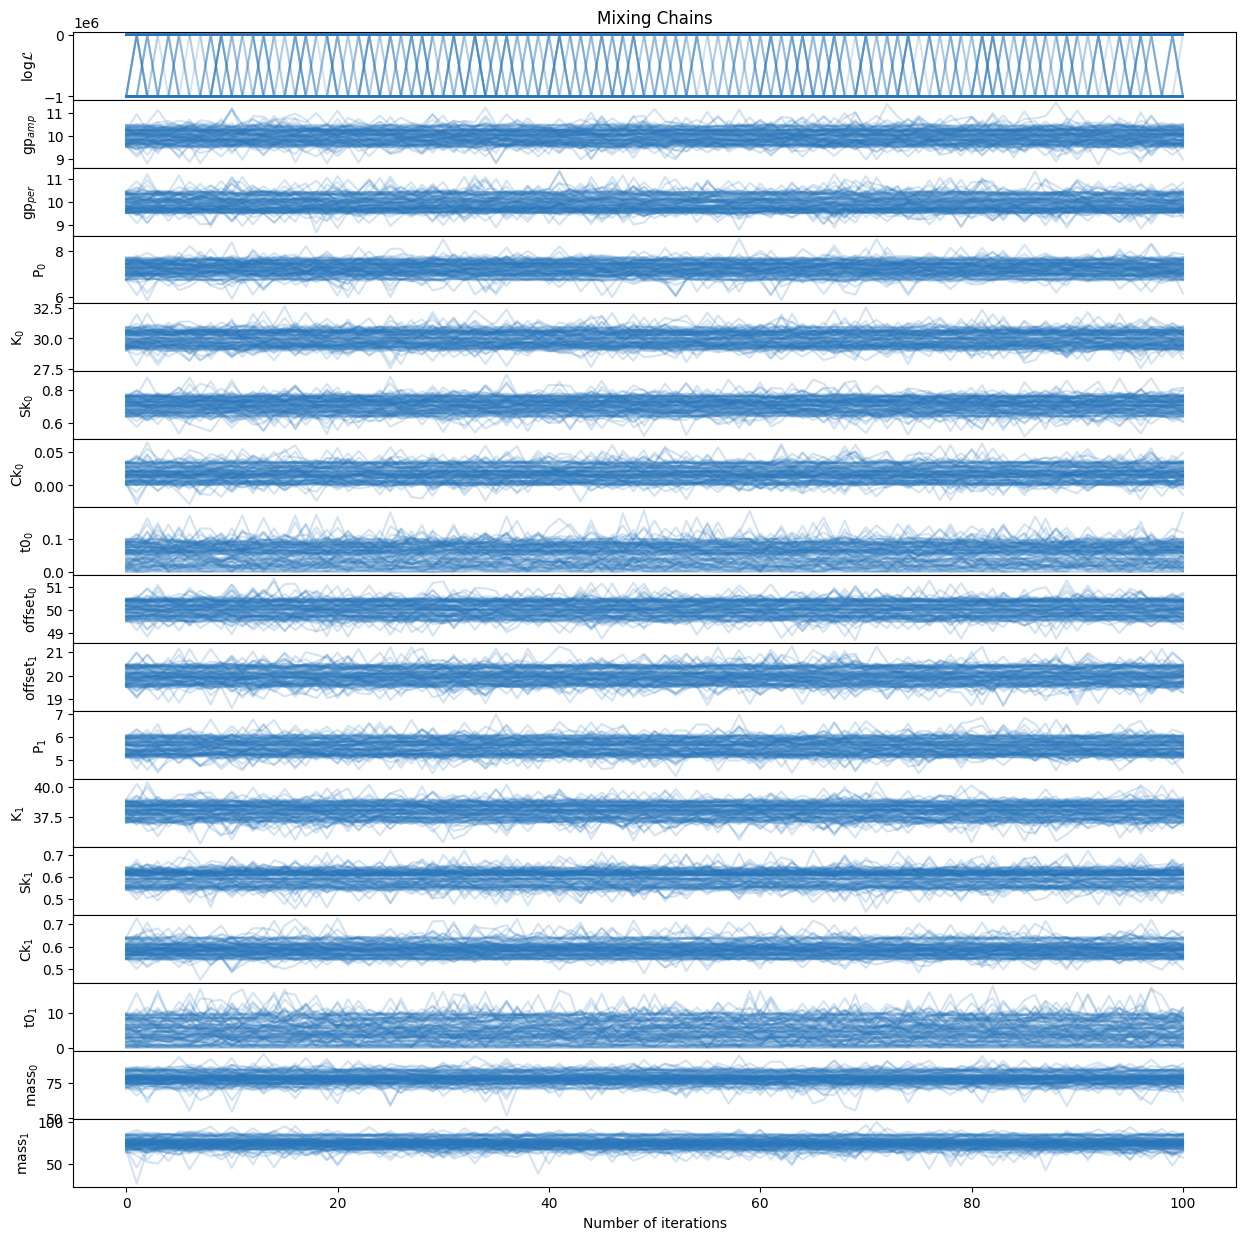

In [22]:

plot.mixing_plot(fin_hparams, "Cosine", fin_model_param, model_list, logL_chain, masses)

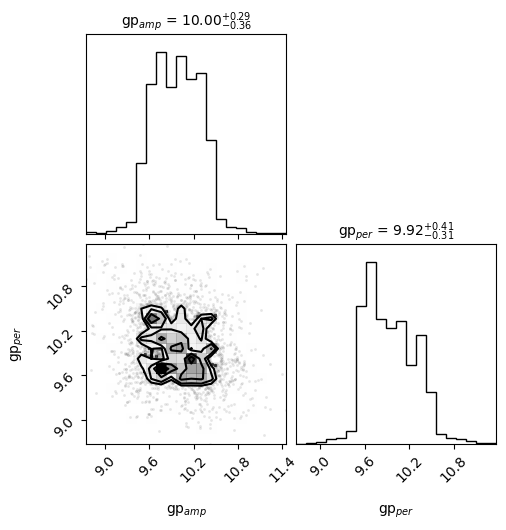

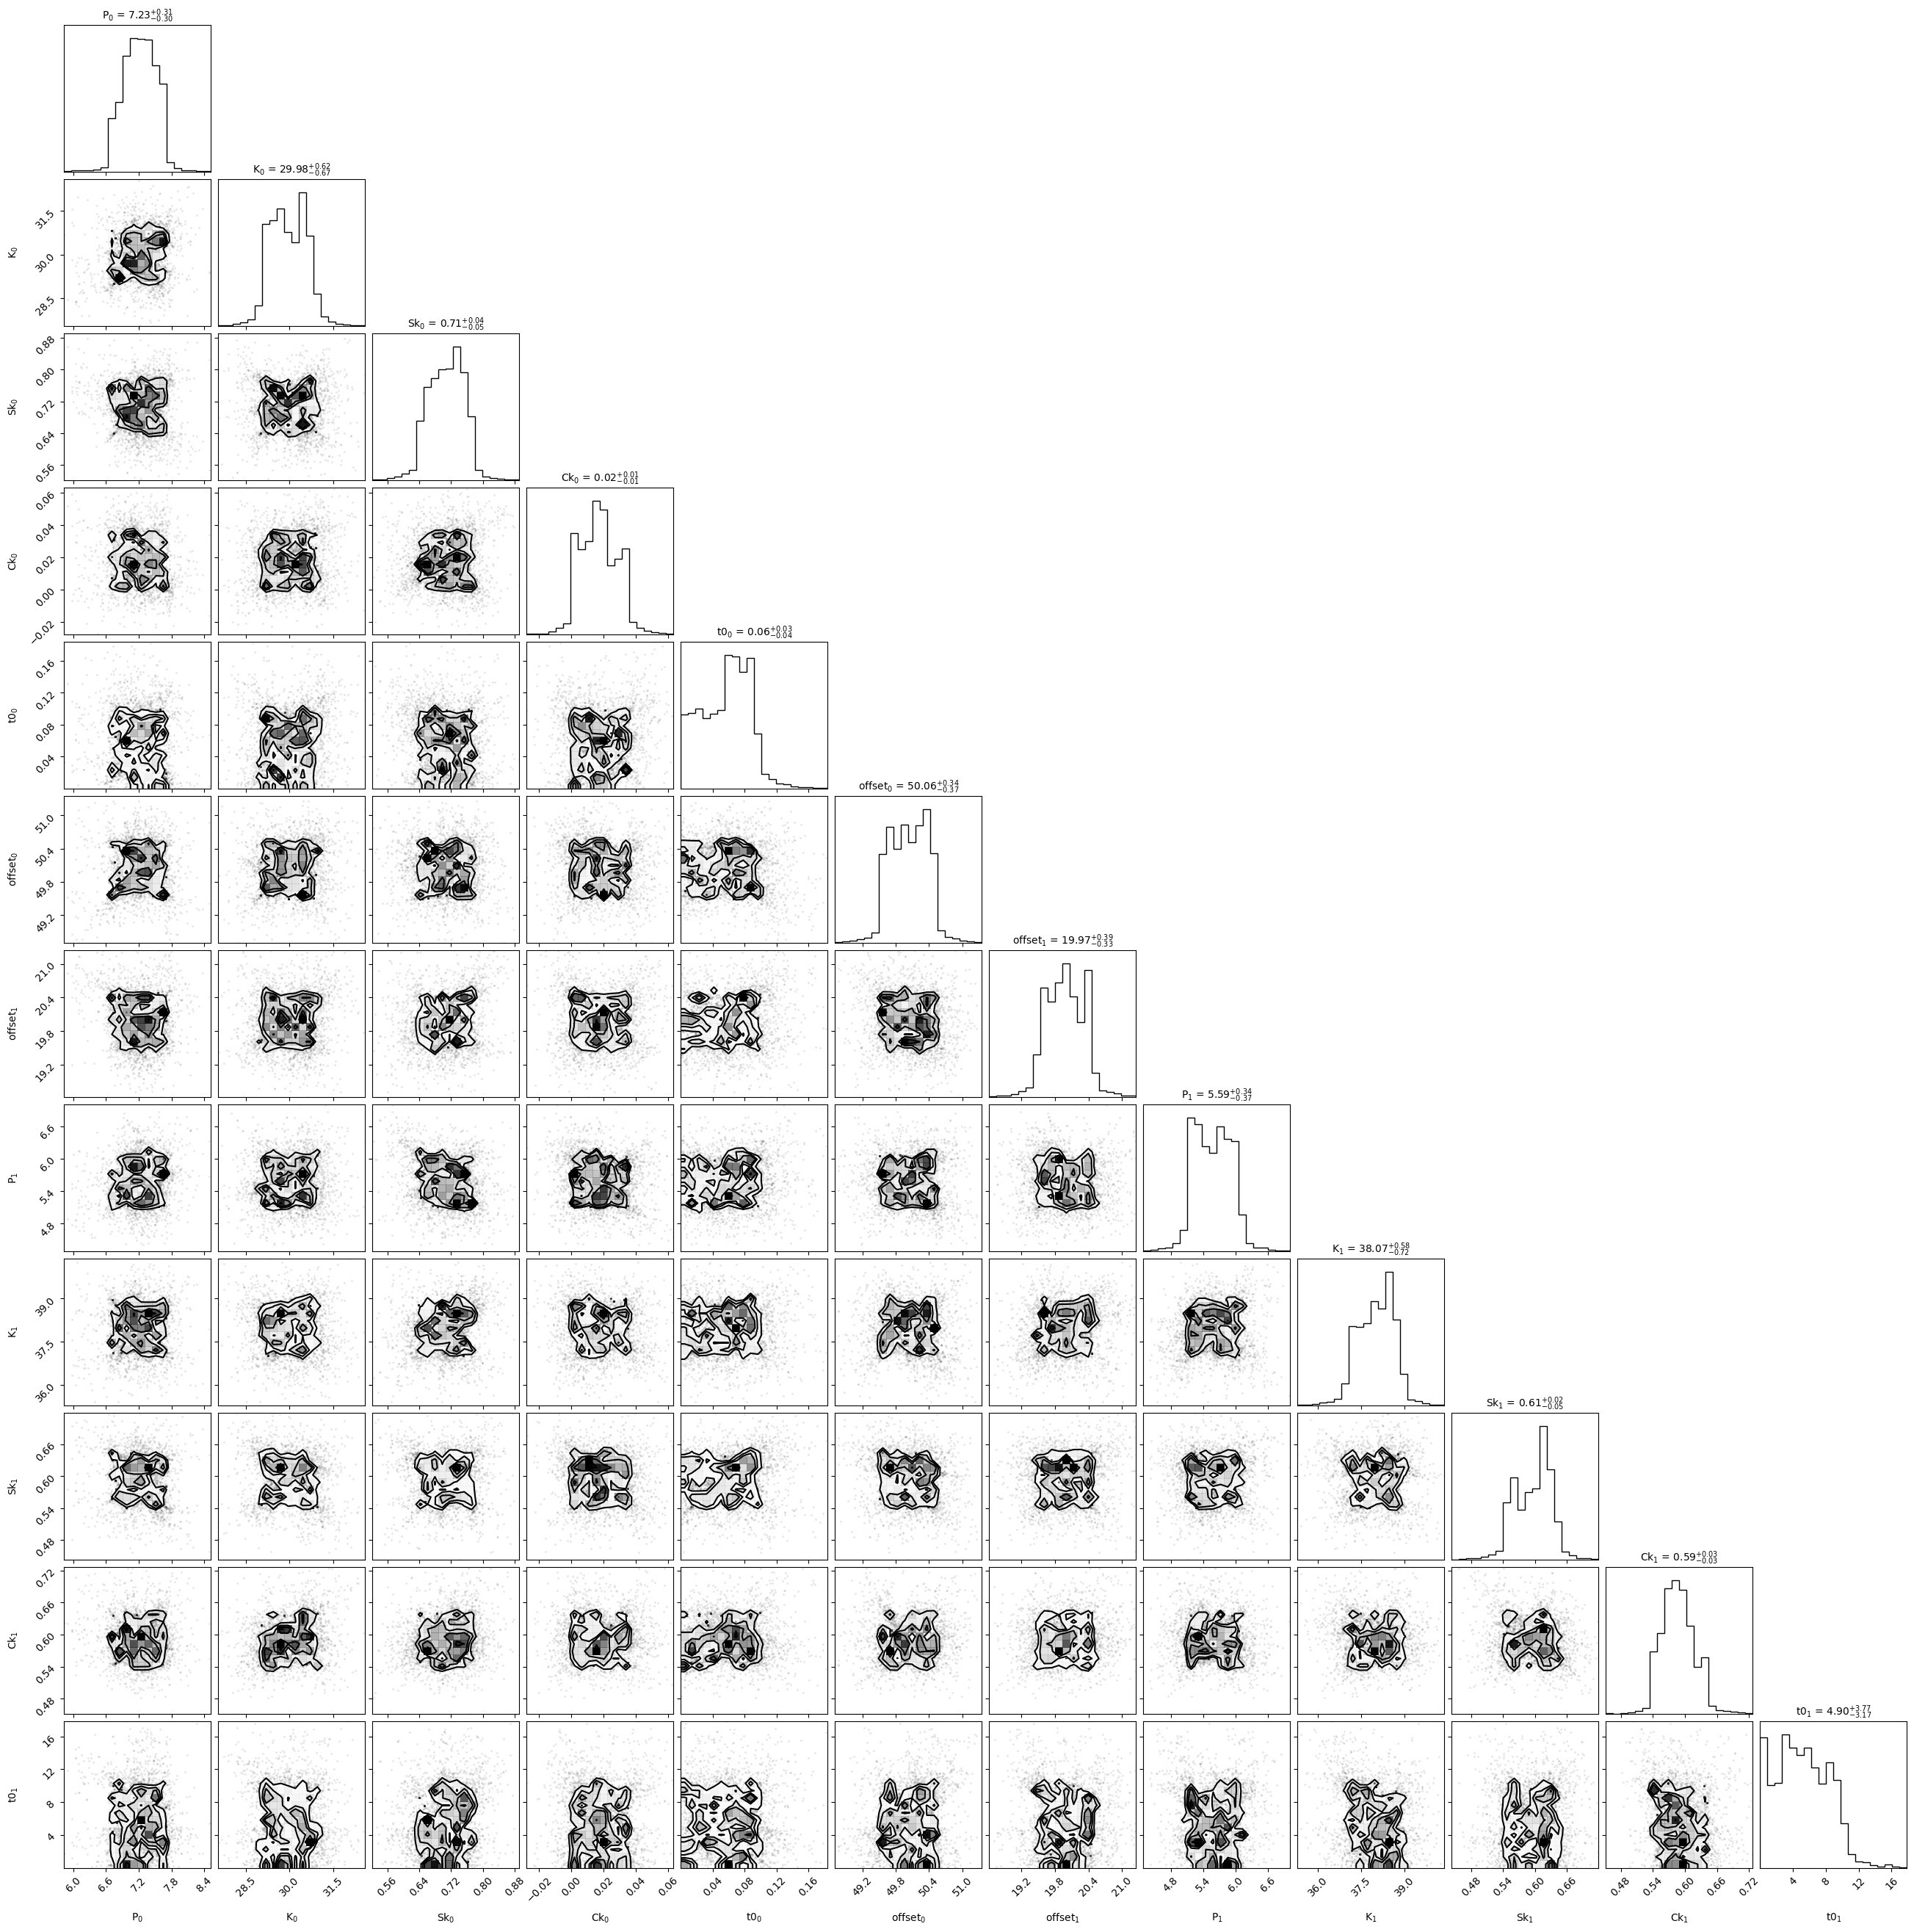

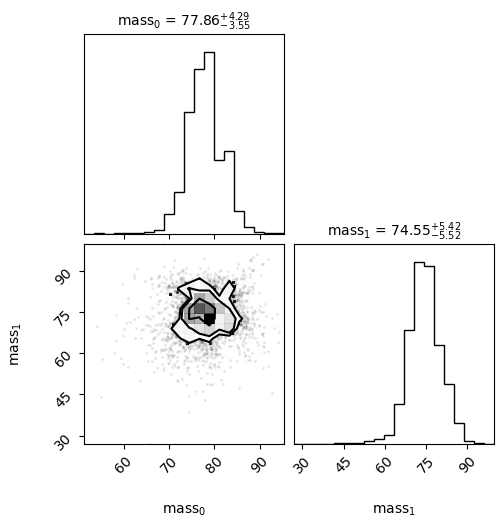

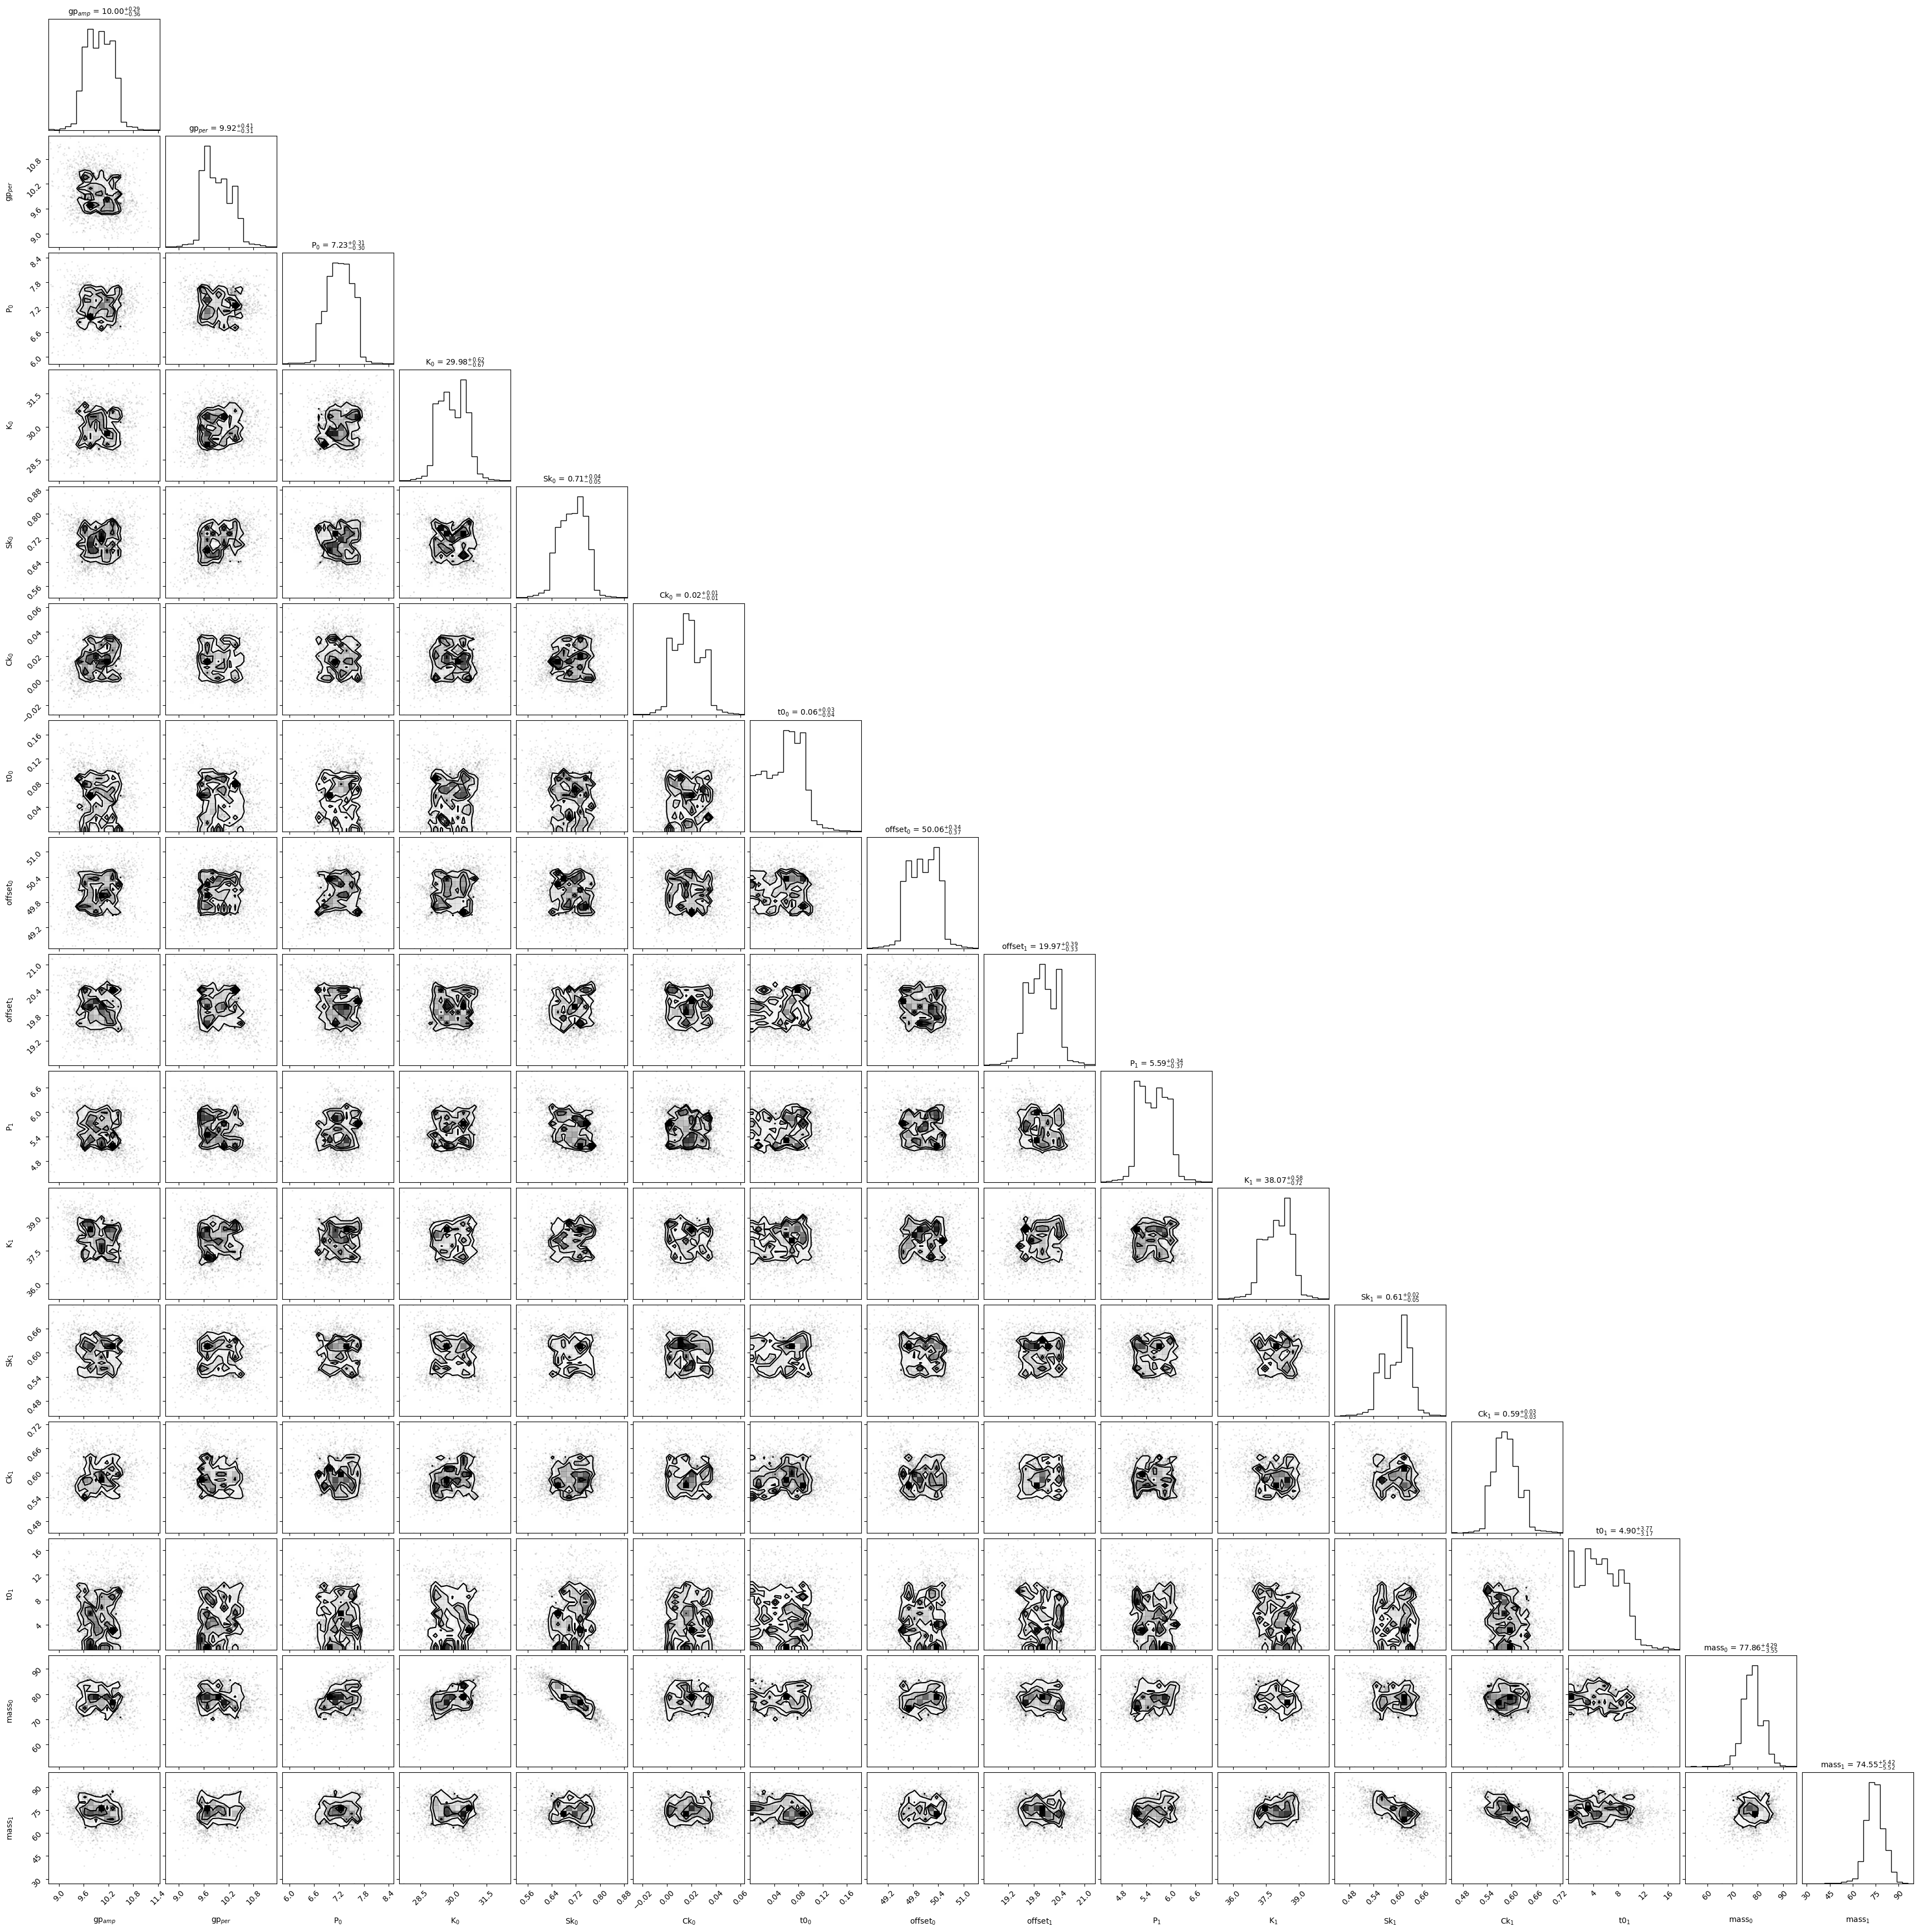

Parameter values after MCMC:  [9.997143116883692, 9.922484258701576, 7.22748940030643, 29.980716507194302, 0.7106043398225849, 0.01664373092469549, 0.05968377866069659, 50.056872257070864, 19.97079427556092, 5.59407574325885, 38.066932861295044, 0.6063823188964313, 0.585613590350137, 4.897681600718897, 77.85562802303211, 74.54771281554297]


In [23]:
final_param_values, final_param_erru, final_param_errd = plot.corner_plot(fin_hparams, "Cosine", fin_model_param, model_list, masses, errors=True)

In [24]:
save('/Users/bdixon/Desktop/MAGPy/Data/tutorial_run/', rv, time, rv_err, model_list = model_list, init_param = model_par, flags = flags, kernel = 'Cosine', init_hparam = hparam, prior_list = prior_list, fin_hparam_post = fin_hparams, fin_param_post = fin_model_param, logl_chain = logL_chain, masses = masses, fin_param_values = final_param_values, fin_param_erru = final_param_erru, fin_param_errd = final_param_errd, burnin = 20, Mstar = 1)